<a href="https://colab.research.google.com/github/gittimos/covid-19-measures/blob/master/Covid_19_measures_(public).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries and data

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [0]:
# function to load data from repository
def load_data(url,countries,start=33):
  dataframe = pd.read_csv(url)
  dataframe = dataframe.loc[dataframe["Country/Region"].isin(countries)].iloc[:,start:].T
  dataframe.columns = countries
  return dataframe, dataframe.diff()

In [0]:
# load data for Germany and Italy from Github
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
countries = ["Germany","Italy"]
cases, cases_new = load_data(url, countries)

In [0]:
# convert index to timestamps
cases.index = pd.to_datetime(cases.index)

In [0]:
# Create third time series with shifted data from Germany for comparison
delta_t = 8 # offset of the time series for comparison
cases_shift = cases.copy()
cases_shift["Germany shifted 8 days"] = cases.Germany.shift(-delta_t)

In [6]:
# latest data
cases.iloc[-1,:]

Germany     5795
Italy      24747
Name: 2020-03-15 00:00:00, dtype: int64

# Plotting the data

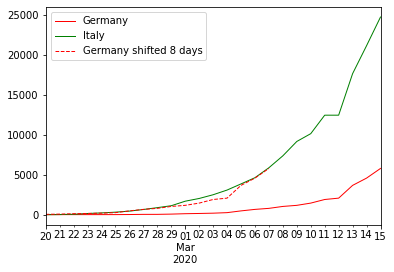

In [7]:
# plot the cases
cases_shift.plot(linewidth=1,style=['r','g','r--'])

# Loglinear plot

In [0]:
cases_log = cases.astype(float).apply(lambda x: np.log(x),axis='rows')

In [0]:
n = cases.index.size
X = np.arange(n).reshape((n,1))

reg_germany = LinearRegression().fit(X, cases_log.Germany)
pred_germany = reg_germany.predict(X)
cases_log["Germany_lin_reg"]=pred_germany

reg_italy = LinearRegression().fit(X, cases_log.Italy)
pred_italy = reg_italy.predict(X)
cases_log["Italy_lin_reg"]=pred_italy

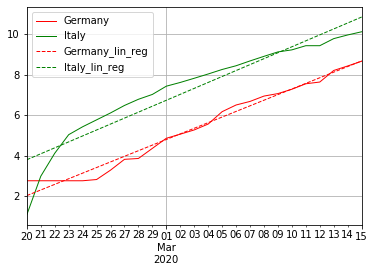

In [10]:
cases_log.plot(linewidth=1,style=['r','g','r--','g--'],grid=True)

# Estimation of growth rate $r$

In [11]:
(r_germany, r_italy) = reg_germany.coef_[0], reg_italy.coef_[0]
(r_germany, r_italy)

(0.2765648687709304, 0.29305310074604335)

# Forecast based on estimate of $r$

In [0]:
def forecast(cases, forecast_period, growth_rates, columns={"Germany": "Germany_forecast", "Italy": "Italy_forecast"}):
  # get latest case numbers 
  last_case_numbner_germany = cases.iloc[-1,0]
  last_case_numbner_italy = cases.iloc[-1,1]
  # extrapolate with growth rates
  forecast_germany = list(map(lambda x: last_case_numbner_germany * np.exp(growth_rates[0]*x), range(1,1+forecast_period)))
  forecast_italy = list(map(lambda x: last_case_numbner_italy * np.exp(growth_rates[1]*x), range(1,1+forecast_period)))
  # create index for forecast dates
  first_day = cases.index.to_series()[-1] + pd.DateOffset(1)
  idx = pd.date_range(first_day, periods=forecast_period, freq='D')
  # add forecast to dataframe
  forecast = pd.DataFrame({'Germany': forecast_germany, 'Italy': forecast_italy},index=idx)
  cases_forecast = cases.append(forecast).rename(columns=columns)
  cases_forecast["Germany"] = cases["Germany"]
  cases_forecast["Italy"] = cases["Italy"]
  return cases_forecast

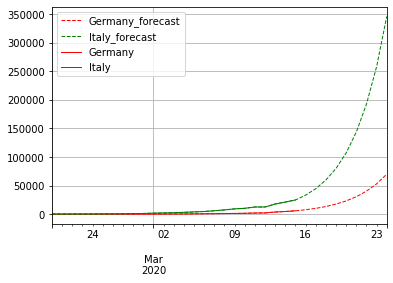

In [13]:
cases_forecast = forecast(cases,9,[r_germany,r_italy])
cases_forecast.plot(linewidth=1,style=['r--','g--','r','g'],grid=True)

# Forecast based on current growth rate

Derive current *n-day* growth rate from data.

In [14]:
n_days = 2
r_inst = np.log(cases.iloc[-1,:]/cases.iloc[-(1+n_days),:])/n_days 
r_inst

Germany    0.227721
Italy      0.168701
dtype: float64

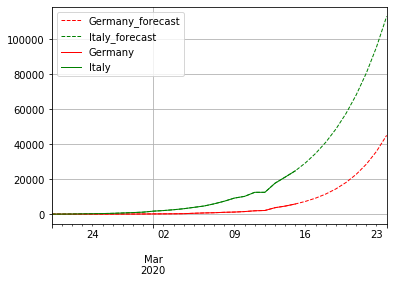

In [15]:
cases_forecast_2 = forecast(cases,9,np.array(r_inst))
cases_forecast_2.plot(linewidth=1,style=['r--','g--','r','g'],grid=True)